In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

from scipy.spatial import distance
import scipy.linalg

## Task 1: Load dataset and Initialize variables

### 1a) Import Data
- Below, using numpy [genfromtxt](https://numpy.org/doc/stable/reference/generated/numpy.genfromtxt.html) load in the datasets (`file_train.csv`, `file_test.csv`). the training set has 800 samples and the test set has 200 samples.

#### Format of data
- Column 1: x coordinate of a 2D point.
- Column 2: y coordinate of a 2D point.
- Column 3: class. Which spiral arm does the point belong to? Labels: [0, 1]

In [62]:
#load dataset
train_data = np.genfromtxt('data/file_train.csv', delimiter = ',')

print(train_data.shape)

x_train = train_data[:,:2]

print(x_train.shape)

y_train = train_data[:,2]

print(y_train.shape)

#y_train = y_train.reshape(800,1)

test_data = np.genfromtxt('data/file_test.csv', delimiter = ',')

x_test = test_data[:,:2]

y_test = test_data[:,2]

#y_test = y_test.reshape(200,1)

print(test_data.shape)


(800, 3)
(800, 2)
(800,)
(200, 3)


### 1b) Create Clusters

1. The number of nodes in the hidden layer will be 8.
2. Because the dataset has 2 classes, the number of output units will be 2.  
3. Create an instance of the [KMeans clustering algorithm class](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), with the number of clusters as the number of nodes in the hidden layer.
    1. Calculate the `cluster_assignments` by fitting the KMeans clustering algorithm to the X_train data, and predicting which clusters X_train would be assigned to.
    2. Assign the cluster centroids to the variable `prototypes`.  
4. Calcuate the `sigmas` for each cluster, the sigma is the mean distance between the points assigned to a centroid and the centroid.
    1. The shape of sigmas should be an array with the length of the number of centroids.
    2. In the lab you can use [cdist](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html) to compute distance between the centroid and the datapoints assigned to it.

In [32]:
np.random.seed(10)

#instance of kmeans
kmeans = KMeans(n_clusters = 8)

#fit kmeans clustering algorithm to x_train
cluster_assignments = kmeans.fit_predict(x_train, y_train)


#assign. cluster centroids to prototypes
prototypes = kmeans.cluster_centers_

#calculate sigmas
sigmas = []

for i in range(prototypes.shape[0]):  
    sigmas.append(np.mean(distance.cdist(x_train[cluster_assignments == i], [prototypes[i]], 'euclidean')))
    
sigmas = np.array(sigmas)

print(sigmas)

[0.32508859 0.34802639 0.33575949 0.32941341 0.30839324 0.3310852
 0.3308535  0.35590776]


### 1c) Visualize Clusters

1. Create a scatterplot of the training data with the x coordinates, y coordinates, coloring the points using the class
2. On the same plot as the scatterplot. Draw the clusters
    1. For each cluster, draw a [circle](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Circle.html) with the center at the prototype coordinates, using the sigma as the radius.  
    2. Add the circle to the axis. [add_patch](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.add_patch.html)
    3. Set the alpha of the circles to .3 and the color to something easily differentiated from the data.
3. Title the plot.

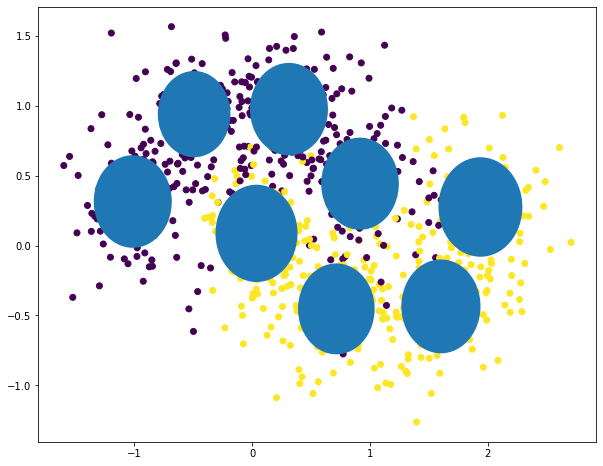

In [67]:
#visualize clusters
import matplotlib.patches as patch

import matplotlib.axes as Axes 


def plot(x,c):
    
    fig, ax = plt.subplots(1,1, figsize = (10,8))

    plt.scatter(x[:,0], x[:,1], c = c)

    for i in range(0,8):  
        ax.add_patch(patch.Circle(prototypes[i], sigmas[i]))
    
    plt.show()

plot(x_train, y_train)


## Train Network

### 2a) Write Hidden Activation Method

1. The hidden activation method should take in 4 parameters: X data, number of hidden nodes, sigmas and prototypes.
2. The hidden activation method should return an hidden activation matrix with the shape `[number of datapoints, number of nodes]`
3. For each hidden node
    1. Calculate $\gamma = \frac{1}{2*(\sigma^2)+1^{-8}}$, with sigma ($\sigma$) representing the distance associated with the node
    2. The activation of hidden unit $j$ to data sample $i$ is computed according to $H_{ij} = \exp \left (-\gamma \left (\text{dist} \left (\vec{x}_i, \vec{c}_j \right )^2\right )\right )$  
where $\vec{x_i}$ is the data sample, $\vec{c_j}$ is the prototype (center) of the hidden unit and $dist(\cdot, \cdot)^2$ is the **squared** Euclidean distance.
    3. Assign the column associated with the hidden node of the activation matrix to the result of the kernel

In [37]:
import math


#hidden activation method
def hidden_activation(x_data, n_hidden_nodes, sigmas, prototypes):
    
    hidden_activation_mat = np.zeros(shape= (x_data.shape[0],n_hidden_nodes))
    
    gamma = 1/(2*sigmas*sigmas+(1e-8))
    
    for i in range(n_hidden_nodes):        
        hidden_activation_mat[:,i] = np.exp(- gamma[i] * np.sum(np.square(x_data - prototypes[i,:]), axis = 1))
               
    return hidden_activation_mat

### 2b) Create Matrices

1. Create a hidden activation layer matrix with the X training data, number of hidden nodes, sigmas and prototypes
2. Append column of 1s to the hidden activation layer matrix for bias using [hstack](https://numpy.org/doc/stable/reference/generated/numpy.hstack.html)
3. Create a weights matrix with the shape of `[number of hidden nodes + 1, number of output nodes]`
4. For each output node
    1. Calculate the linear regression using scipy's Least Squares method (https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lstsq.html) with the hidden activation layer matrix as the left-hand side array and whether each data point is associated with that output node as the right hand side array (boolean array of length number of datapoints).
    2. Assign the column associated with the output node of the weights matrix to the least-squares solution
5. Print the resulting weights matrix

In [63]:
#Create a hidden activation layer matrix
hidden_layer = hidden_activation(x_train, 8, sigmas, prototypes)

hidden_layer = np.column_stack((hidden_layer, np.ones(hidden_layer.shape[0])))

print(hidden_layer.shape)

weights = np.empty([hidden_layer.shape[1], 2])

print(weights.shape)

for i in range(2):
    x,_,_,_ = scipy.linalg.lstsq(hidden_layer, y_train == i)
    
    weights[:,i] = x       
    
print(weights)

(800, 9)
(9, 2)
[[-0.44727824  0.44727824]
 [-0.53848313  0.53848313]
 [-0.52404487  0.52404487]
 [ 0.62788033 -0.62788033]
 [ 0.64056336 -0.64056336]
 [ 0.70733222 -0.70733222]
 [ 0.58239364 -0.58239364]
 [-0.47102748  0.47102748]
 [ 0.46780245  0.53219755]]


### 2c) Visualize Model

1. Create a scatterplot of the training data with the x coordinates, y coordinates, coloring the points using the class
2. On the same plot as the scatterplot. Draw the circles to represent the clusters and color them based on the resulting weights.
    1. For each cluster, draw a circle with the center at the prototype coordinates, using the sigma as the radius. 
    2. Set the alpha of the circles to .3
    3. Using the weights, determine whether that node represents the first class or the second.  Color the classes different colors.
3. Title the plot.

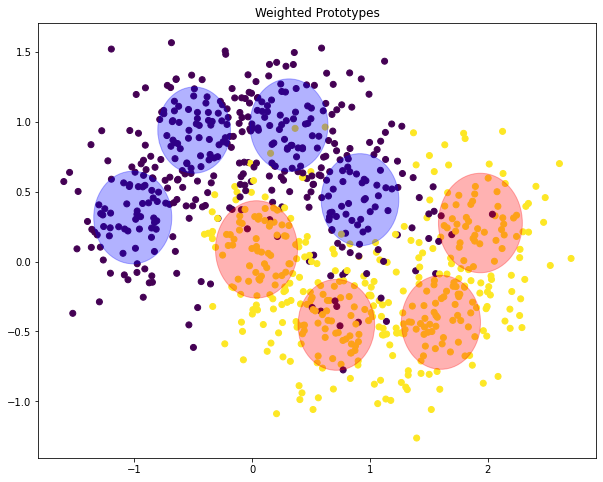

In [73]:
#scatter plot of training data with x coordinates, y coordinates, coloring points using class
fig, ax = plt.subplots(1,1, figsize = (10,8))

ax.scatter(x_train[:,0], x_train[:,1], c = y_train)

for i in range(prototypes.shape[0]):   
    c = 'r'
    if weights[i,0] > 0:
        c = 'b'
    ax.add_patch(patch.Circle(prototypes[i], sigmas[i], alpha = 0.3, color = c))
    
ax.title.set_text("Weighted Prototypes")
    